In [1]:
import dask
from dask.diagnostics import ProgressBar
from datatree import DataTree
import itertools as it
from pathlib import Path
import geopandas as gpd
from cartopy import crs, feature as cfeat
from clisops.core.subset import create_weight_masks, subset_bbox
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shapely as sh
import xarray as xr
import xclim as xc
import xclim.ensembles as xce
import xesmf as xe
import xscen as xs
dask.diagnostics.ProgressBar().register()
dask.config.set(num_workers=10, scheduler='threads')

2023-04-13 10:29:44,416 - pint.util - WARNING - Redefining 'year' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-04-13 10:29:44,421 - pint.util - WARNING - Redefining 'yr' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-04-13 10:29:44,424 - pint.util - WARNING - Redefining 'C' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-04-13 10:29:44,429 - pint.util - WARNING - Redefining 'd' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-04-13 10:29:44,432 - pint.util - WARNING - Redefining 'h' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-04-13 10:29:44,435 - pint.util - WARNING - Redefining 'degrees_north' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-04-13 10:29:44,439 - pint.util - WARNING - Redefining 'degrees_east' (<class 'pint.delegates.txt_defparser.plain.UnitDefinition'>)
2023-04-13 10:29:44,442 - pint.util - WARNING - Redefining '[speed]' (<class 'pint.delegates.txt_d

In [15]:
root = Path('/exec/pbourg/ESPO-G/indsanal/')
cat = xs.DataCatalog('/exec/pbourg/ESPO-G/indsanal/catalog.json')
cat.esmcat._df['id'] = xs.catalog.generate_id(cat.df)
probreg = dict(
    name="prob-reg",
    method="bbox",
    bbox=dict(
        lat_bnds=[45, 47],
        lon_bnds=[-75, -70]
    ),
)

pgp = sh.geometry.box(-70, 45, -75, 47)
regions = gpd.read_file('/exec/pbourg/PC/20230406/regions_simplified_admin.geojson')
estrie = regions.iloc[[29]]
estrie

,id,name,geometry
29,30,Estrie,"POLYGON ((-71.06889 45.92744, -71.05771 45.938..."


In [3]:
def delta_series(da):
    return da - da.sel(time=slice('1981', '2010')).mean('time')

def delta(da):
    return da.sel(time=slice('2071', '2100')).mean('time') - da.sel(time=slice('1981', '2010')).mean('time')

In [4]:
rgb = np.loadtxt('/home/pbourg/Projets/IPCC-Colormaps/continuous_colormaps_rgb_0-1/misc_seq_3.txt')
cmap = mpl.colors.LinearSegmentedColormap.from_list('misc_seq_3', rgb)

## Deltas QC

In [5]:
ens = (
    xs.DataCatalog('/jarre/scenario/jlavoie/ESPO-G6/cat_ESPO-G6_RDRS.json')
    .search(domain='QC-rdrs', experiment='ssp245', variable='dlyfrzthw', xrfreq='AS-JAN', processing_level='indicators')
    .to_dataset(
        create_ensemble_on=['institution', 'source', 'member'],
        xarray_open_kwargs={'decode_timedelta': False},
        xarray_combine_by_coords_kwargs={'compat': 'override', 'coords': 'minimal', 'data_vars': 'minimal'}
    )
)
ens = xs.extract.clisops_subset(ens, region={'name': 'QC', 'method': 'shape', 'shape': {'shape': '/exec/pbourg/PC/20230406/regions_simplified_qc.geojson'}})
pres = ens.sel(time=slice('1981', '2010')).mean('time')
fut = ens.sel(time=slice('2071', '2100')).mean('time')
dEG6R2 = xce.ensemble_percentiles(fut - pres, values=[10, 50, 90], split=False)


[########################################] | 100% Completed | 26.35 s
[                                        ] | 0% Completed | 113.18 ms

/home/pbourg/Projets/xscen/xscen/extract.py:76: UserWarning: Loading longitude and latitude for more efficient subsetting.


[########################################] | 100% Completed | 138.70 s


In [6]:
ens = (
    xs.DataCatalog('/exec/pbourg/ESPO-G/cat_ESPO-G6.json')
    .search(domain='QC-nrcan', experiment='ssp245', variable='dlyfrzthw', xrfreq='AS-JAN', processing_level='indicators')
    .to_dataset(
        create_ensemble_on=['institution', 'source', 'member'],
        xarray_open_kwargs={'decode_timedelta': False},
        xarray_combine_by_coords_kwargs={'compat': 'override', 'coords': 'minimal', 'data_vars': 'minimal'}
    )
)
#ens = xs.extract.clisops_subset(ens, region={'name': 'QC', 'method': 'shape', 'shape': {'shape': '/exec/pbourg/PC/20230406/regions_simplified_qc.geojson'}})
pres = ens.sel(time=slice('1981', '2010')).mean('time')
fut = ens.sel(time=slice('2071', '2100')).mean('time')
dEG6N1 = xce.ensemble_percentiles(fut - pres, values=[10, 50, 90], split=False)

[########################################] | 100% Completed | 21.10 s


In [7]:
ens = (
    xs.DataCatalog('/tank/scenario/catalogues/ESPO-extra.json')
    .search(bias_adjust_project='ScenGen', experiment='rcp45', variable='dlyfrzthw', xrfreq='AS-JAN')
    .to_dataset(
        create_ensemble_on=['institution', 'source', 'member'],
        xarray_open_kwargs={'decode_timedelta': False},
        xarray_combine_by_coords_kwargs={'compat': 'override', 'coords': 'minimal', 'data_vars': 'minimal'}
    )
)
pres = ens.sel(time=slice('1981', '2010')).mean('time')
fut = ens.sel(time=slice('2071', '2100')).mean('time')
dSG = xce.ensemble_percentiles(fut - pres, values=[10, 50, 90], split=False)

[########################################] | 100% Completed | 2.17 ss


In [8]:
ens = xce.create_ensemble(
    cat.search(
        bias_adjust_project='pcic', mip_era='CMIP6', experiment='ssp245',
        domain='QC', xrfreq='mon'
    ).df.path,
    engine='zarr'
).resample(time='YS').sum()
pres = ens.sel(time=slice('1981', '2010')).mean('time')
fut = ens.sel(time=slice('2071', '2100')).mean('time')
dPCIC = xce.ensemble_percentiles(fut - pres, values=[10, 50, 90], split=False)

In [9]:
dEG6R2, dEG6N1, dPCIC, dSG = dask.compute(dEG6R2.dlyfrzthw, dEG6N1.dlyfrzthw, dPCIC.dlyfrzthw, dSG.dlyfrzthw)

[########################################] | 100% Completed | 160.97 s


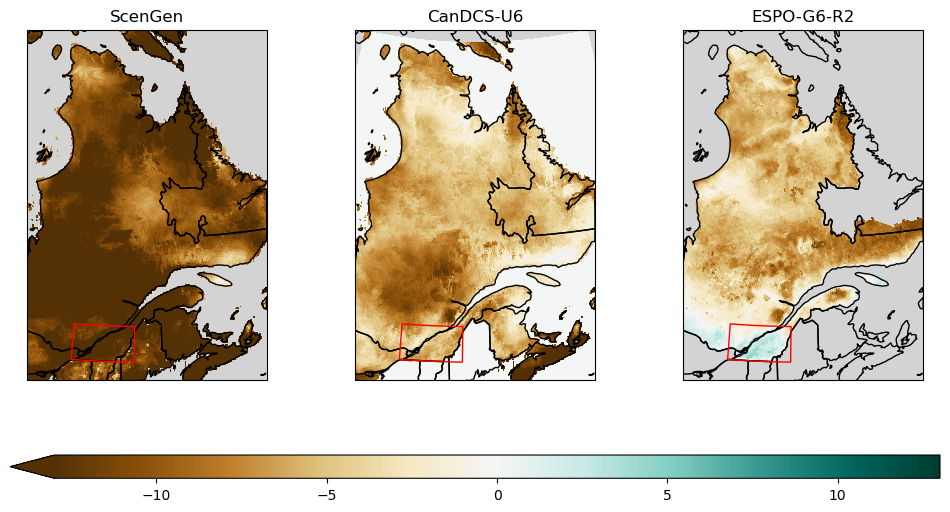

In [10]:
pPC = crs.PlateCarree()
pRD = crs.RotatedPole(
    pole_longitude=dEG6R2.rotated_pole.grid_north_pole_longitude,
    pole_latitude=dEG6R2.rotated_pole.grid_north_pole_latitude,
    central_rotated_longitude=dEG6R2.rotated_pole.longitude_of_prime_meridian
)

fig, axs = plt.subplots(1, 3, figsize=(12, 6.5), subplot_kw={'projection': crs.UTM(19)})

#vmin = min(dEG6R2.min(), -dEG6R2.max(), dSG.min(), -dSG.max()) 
vmin = -13
vmax = -vmin

for ds, p, lbl, ax in zip([dSG, dPCIC, dEG6R2.drop_vars(['lon', 'lat'])], [pPC, pPC, pRD], ['ScenGen', 'CanDCS-U6', 'ESPO-G6-R2'], axs):
    if ds is not None:
        m = ds.sel(percentiles=50).plot(
            ax=ax, cmap=plt.cm.BrBG, vmin=vmin, vmax=vmax, add_colorbar=False,
            transform=p,
        )
    else:
        ax.text(0.1, 0.4, 'Coming soon!', transform=ax.transAxes, color='red')
    ax.set_extent((-83, -55, 44, 63), crs=pPC)
    ax.set_title(lbl)
    ax.add_feature(cfeat.STATES)
    ax.add_geometries([pgp], crs=pPC, facecolor='none', edgecolor='r')
    ax.set_facecolor('lightgrey')
fig.colorbar(m, ax=axs, extend='min', orientation='horizontal', aspect=40)
fig.savefig('Delta_maps_QC.png', bbox_inches='tight')

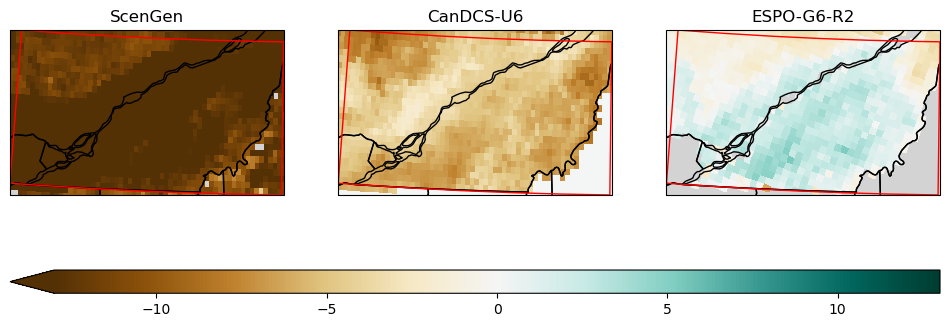

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6.5), subplot_kw={'projection': crs.UTM(19)})

#vmin = min(dEG6R2.min(), -dEG6R2.max(), dSG.min(), -dSG.max()) 
vmin = -13
vmax = -vmin

for ds, p, lbl, ax in zip([dSG, dPCIC, dEG6R2.drop_vars(['lon', 'lat'])], [pPC, pPC, pRD], ['ScenGen', 'CanDCS-U6', 'ESPO-G6-R2'], axs):
    if ds is not None:
        m = ds.sel(percentiles=50).plot(
            ax=ax, cmap=plt.cm.BrBG, vmin=vmin, vmax=vmax, add_colorbar=False,
            transform=p,
        )
    else:
        ax.text(0.1, 0.4, 'Coming soon!', transform=ax.transAxes, color='red')
    ax.set_extent((-75, -70, 45, 47), crs=pPC)
    ax.set_title(lbl)
    ax.add_feature(cfeat.STATES)
    ax.add_geometries([pgp], crs=pPC, facecolor='none', edgecolor='r')
    ax.set_facecolor('lightgrey')
fig.colorbar(m, ax=axs, extend='min', orientation='horizontal', aspect=40)
fig.savefig('Delta_maps_prob-reg.png', bbox_inches='tight')

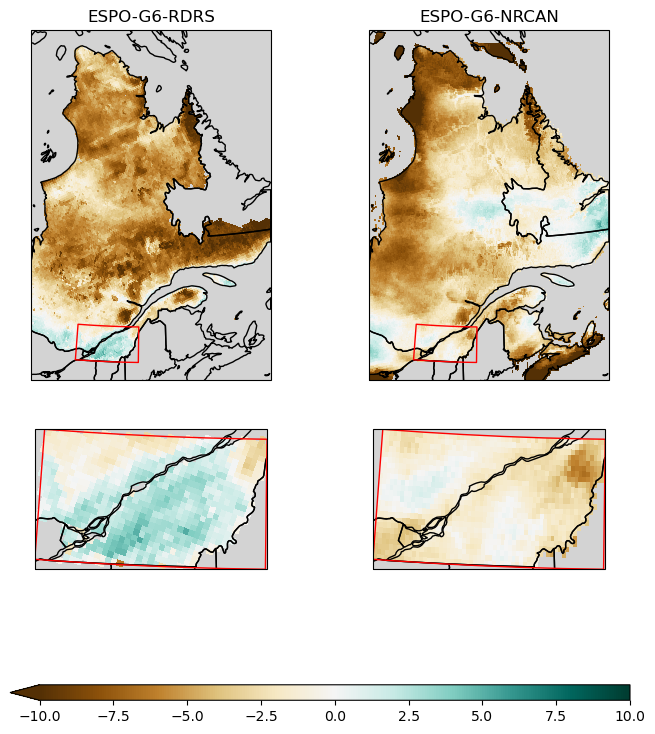

In [12]:
fig, axs = plt.subplots(
    2, 2,
    figsize=(8, 10),
    subplot_kw={'projection': crs.UTM(19)},
    gridspec_kw={'height_ratios': [2.5, 1]}
)

vmax = 10
vmin = -10

for ds, p, lbl, ax in zip([dEG6R2, dEG6N1], [pRD, pPC], ['ESPO-G6-RDRS', 'ESPO-G6-NRCAN'], axs[0]):
    m = ds.sel(percentiles=50).plot(
        ax=ax, cmap=plt.cm.BrBG, vmin=vmin, vmax=vmax, add_colorbar=False,
        transform=p,
    )
    ax.set_extent((-83, -55, 44, 63), crs=pPC)
    ax.set_title(lbl)
    ax.add_feature(cfeat.STATES)
    ax.add_geometries([pgp], crs=pPC, facecolor='none', edgecolor='r')
    ax.set_facecolor('lightgrey')
for ds, p, lbl, ax in zip([dEG6R2, dEG6N1], [pRD, pPC], ['RDRS', 'NRCAN'], axs[1]):
    m = xs.extract.clisops_subset(ds.sel(percentiles=50), region=probreg).plot(
        ax=ax, cmap=plt.cm.BrBG, vmin=vmin, vmax=vmax, add_colorbar=False,
        transform=p,
    )
    ax.set_extent((-75, -70, 45, 47), crs=pPC)
    ax.add_feature(cfeat.STATES)
    ax.add_geometries([pgp], crs=pPC, facecolor='none', edgecolor='r')
    ax.set_facecolor('lightgrey')
    ax.set_title('')
fig.colorbar(m, ax=axs, extend='min', orientation='horizontal', aspect=40)
fig.savefig('Delta_maps_ESPO.png', bbox_inches='tight')

## Timeseries

In [16]:
ens = (
    xs.DataCatalog('/tank/scenario/catalogues/ESPO-extra.json')
    .search(bias_adjust_project='ScenGen', experiment='rcp45', variable='dlyfrzthw', xrfreq='AS-JAN')
    .to_dataset(
        create_ensemble_on=['institution', 'source', 'member'],
        xarray_open_kwargs={'decode_timedelta': False},
        xarray_combine_by_coords_kwargs={'compat': 'override', 'coords': 'minimal', 'data_vars': 'minimal'}
    )
)
ens = (
    xs.extract.clisops_subset(ens, region=probreg)
    .mean(['lat', 'lon'])
)
tSG = (
    ens
    .chunk({'time': -1, 'realization': -1})
    .rolling(time=30, center=True)
    .construct('window')
    .quantile([0.1, 0.5, 0.9], ['window', 'realization'])
)
tdSG = (
    ens
    .pipe(delta_series)
    .chunk({'time': -1, 'realization': -1})
    .rolling(time=30, center=True)
    .construct('window')
    .quantile([0.1, 0.5, 0.9], ['window', 'realization'])
)

[########################################] | 100% Completed | 1.86 ss


In [17]:
ens = xce.create_ensemble(
    cat.search(
        bias_adjust_project='pcic', mip_era='CMIP6', experiment='ssp245',
        domain='prob-reg', xrfreq='mon'
    ).df.path,
    engine='zarr'
).dlyfrzthw.resample(time='YS').sum().mean(['lat', 'lon'])
tPCIC = (
    ens
    .chunk({'time': -1, 'realization': -1})
    .rolling(time=30, center=True)
    .construct('window')
    .quantile([0.1, 0.5, 0.9], ['window', 'realization'])
)
tdPCIC = (
    ens
    .chunk({'time': -1, 'realization': -1})
    .pipe(delta_series)
    .rolling(time=30, center=True)
    .construct('window')
    .quantile([0.1, 0.5, 0.9], ['window', 'realization'])
)

In [18]:
ensd = cat.search(
    bias_adjust_project='raw', mip_era='CMIP6', experiment='ssp245',
    domain='prob-reg', xrfreq='mon'
).to_dataset_dict(xarray_open_kwargs=dict(engine='zarr', decode_timedelta=False))

ens = xce.create_ensemble({
    k: dd.sel(time=slice('1950', '2100')).dlyfrzthw.resample(time='YS').sum().mean(['lat', 'lon'])
    for k, dd in ensd.items()
})
tCMIP6 = (
    ens
    .chunk({'time': -1, 'realization': -1})
    .rolling(time=30, center=True)
    .construct('window')
    .quantile([0.1, 0.5, 0.9], ['window', 'realization'])
)
tdCMIP6 = (
    ens
    .chunk({'time': -1, 'realization': -1})
    .pipe(delta_series)
    .rolling(time=30, center=True)
    .construct('window')
    .quantile([0.1, 0.5, 0.9], ['window', 'realization'])
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'
[                                        ] | 0% Completed | 290.82 us

[########################################] | 100% Completed | 1.37 ss


In [19]:
ensd = cat.search(
    bias_adjust_project='raw', mip_era='CMIP5', experiment='rcp45',
    domain='prob-reg', xrfreq='mon'
).to_dataset_dict(xarray_open_kwargs=dict(engine='zarr', decode_timedelta=False))

ens = xce.create_ensemble({
    k: dd.sel(time=slice('1950', '2100')).dlyfrzthw.resample(time='YS').sum().mean(['lat', 'lon'])
    for k, dd in ensd.items()
})
tCMIP5 = (
    ens
    .chunk({'time': -1, 'realization': -1})
    .rolling(time=30, center=True)
    .construct('window')
    .quantile([0.1, 0.5, 0.9], ['window', 'realization'])
)
tdCMIP5 = (
    ens
    .chunk({'time': -1, 'realization': -1})
    .pipe(delta_series)
    .rolling(time=30, center=True)
    .construct('window')
    .quantile([0.1, 0.5, 0.9], ['window', 'realization'])
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'id.domain.processing_level.xrfreq'
[                                        ] | 0% Completed | 9.39 ms

[                                        ] | 0% Completed | 119.10 ms

/exec/pbourg/.conda/xscen/lib/python3.10/site-packages/xarray/coding/times.py:699: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range


[                                        ] | 0% Completed | 246.44 ms

/exec/pbourg/.conda/xscen/lib/python3.10/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range


[########################################] | 100% Completed | 407.12 ms


In [20]:
ens = (
    xs.DataCatalog('/jarre/scenario/jlavoie/ESPO-G6/cat_ESPO-G6_RDRS.json')
    .search(domain='QC-rdrs', experiment='ssp245', variable='dlyfrzthw', xrfreq='AS-JAN', processing_level='indicators')
    .to_dataset(
        create_ensemble_on=['institution', 'source', 'member'],
        xarray_open_kwargs={'decode_timedelta': False},
        xarray_combine_by_coords_kwargs={'compat': 'override', 'coords': 'minimal', 'data_vars': 'minimal'}
    )
)
ens = (
    xs.extract.clisops_subset(ens, region=probreg)
    .mean(['rlat', 'rlon'])
)
tEG6R2 = (
    ens
    .chunk({'time': -1, 'realization': -1})
    .rolling(time=30, center=True)
    .construct('window')
    .quantile([0.1, 0.5, 0.9], ['window', 'realization'])
)
tdEG6R2 = (
    ens
    .chunk({'time': -1, 'realization': -1})
    .pipe(delta_series)
    .rolling(time=30, center=True)
    .construct('window')
    .quantile([0.1, 0.5, 0.9], ['window', 'realization'])
)

[########################################] | 100% Completed | 3.44 ss
[                                        ] | 0% Completed | 109.19 ms

/home/pbourg/Projets/xscen/xscen/extract.py:76: UserWarning: Loading longitude and latitude for more efficient subsetting.


[########################################] | 100% Completed | 2.15 sms


In [21]:
ens = (
    xs.DataCatalog('/exec/pbourg/ESPO-G/cat_ESPO-G6.json')
    .search(domain='QC-nrcan', experiment='ssp245', variable='dlyfrzthw', xrfreq='AS-JAN', processing_level='indicators')
    .to_dataset(
        create_ensemble_on=['institution', 'source', 'member'],
        xarray_open_kwargs={'decode_timedelta': False},
        xarray_combine_by_coords_kwargs={'compat': 'override', 'coords': 'minimal', 'data_vars': 'minimal'}
    )
)
ens = (
    xs.extract.clisops_subset(ens, region=probreg)
    .mean(['lat', 'lon'])
)
tEG6N1 = (
    ens
    .chunk({'time': -1, 'realization': -1})
    .rolling(time=30, center=True)
    .construct('window')
    .quantile([0.1, 0.5, 0.9], ['window', 'realization'])
)
tdEG6N1 = (
    ens
    .chunk({'time': -1, 'realization': -1})
    .pipe(delta_series)
    .rolling(time=30, center=True)
    .construct('window')
    .quantile([0.1, 0.5, 0.9], ['window', 'realization'])
)

[########################################] | 100% Completed | 2.40 ss


In [22]:
tSG, tPCIC, tEG6R2, tEG6N1, tCMIP6, tCMIP5, tdSG, tdPCIC, tdEG6R2, tdEG6N1, tdCMIP6, tdCMIP5 = dask.compute(
    tSG.dlyfrzthw, tPCIC, tEG6R2.dlyfrzthw, tEG6N1.dlyfrzthw, tCMIP6.dlyfrzthw, tCMIP5.dlyfrzthw,
    tdSG.dlyfrzthw, tdPCIC, tdEG6R2.dlyfrzthw, tdEG6N1.dlyfrzthw, tdCMIP6.dlyfrzthw, tdCMIP5.dlyfrzthw,
)

[########################################] | 100% Completed | 4.93 sms


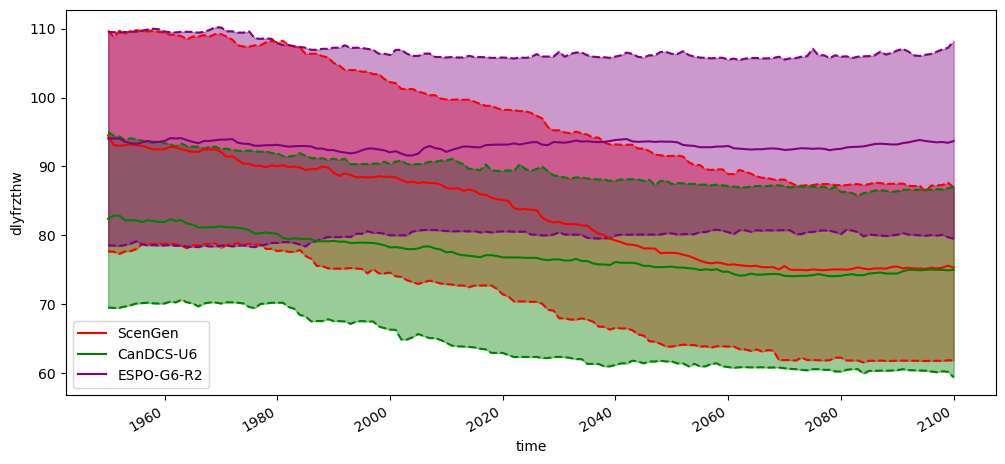

In [23]:
fig, ax = plt.subplots(figsize=(12, 5))

for da, col in zip([tSG, tPCIC, tEG6R2], ['red', 'green', 'purple']):
    ax.fill_between(
        da.convert_calendar('standard').time,
        da.sel(quantile=0.1),
        da.sel(quantile=0.9),
        color=col,
        alpha=0.4,
    )
    da.convert_calendar('standard').sel(quantile=0.1).plot(ax=ax, color=col, linestyle='--')
    da.convert_calendar('standard').sel(quantile=0.9).plot(ax=ax, color=col, linestyle='--')
for da, col, lbl in zip([tSG, tPCIC, tEG6R2], ['red', 'green', 'purple'], ['ScenGen', 'CanDCS-U6', 'ESPO-G6-R2']):
    da.convert_calendar('standard').sel(quantile=0.5).plot(ax=ax, label=lbl, color=col)
ax.legend()
ax.set_title('')
fig.savefig('Tseries_prob-reg.png', bbox_inches='tight')

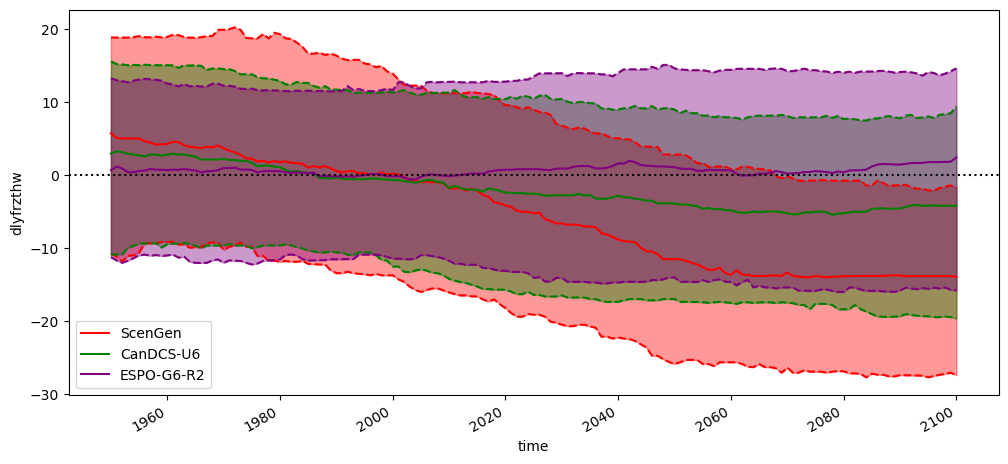

In [24]:
fig, ax = plt.subplots(figsize=(12, 5))

for da, col in zip([tdSG, tdPCIC, tdEG6R2], ['red', 'green', 'purple']):
    ax.fill_between(
        da.convert_calendar('standard').time,
        da.sel(quantile=0.1),
        da.sel(quantile=0.9),
        color=col,
        alpha=0.4,
    )
    da.convert_calendar('standard').sel(quantile=0.1).plot(ax=ax, color=col, linestyle='--')
    da.convert_calendar('standard').sel(quantile=0.9).plot(ax=ax, color=col, linestyle='--')
for da, col, lbl in zip([tdSG, tdPCIC, tdEG6R2], ['red', 'green', 'purple'], ['ScenGen', 'CanDCS-U6', 'ESPO-G6-R2']):
    da.convert_calendar('standard').sel(quantile=0.5).plot(ax=ax, label=lbl, color=col)
ax.legend()
ax.set_title('')
ax.axhline(0, color='k', linestyle=':')
fig.savefig('Deltaseries_prob-reg.png', bbox_inches='tight')

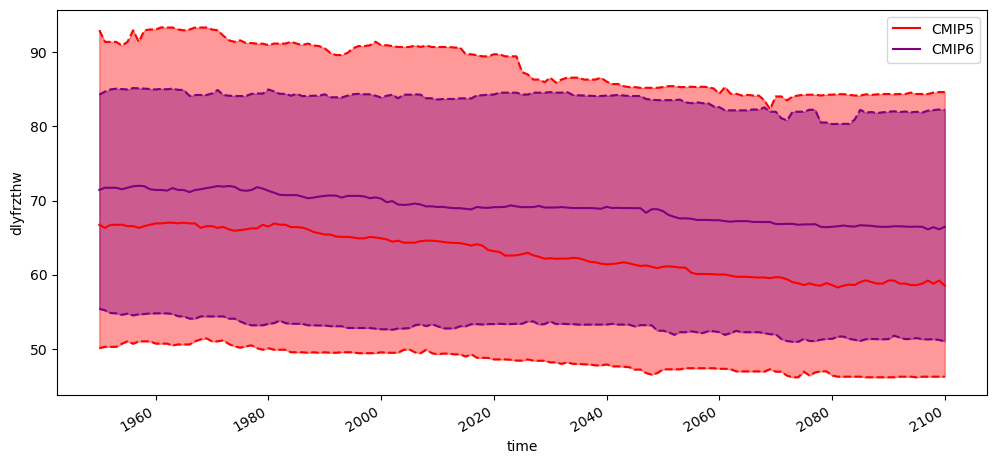

In [25]:
fig, ax = plt.subplots(figsize=(12, 5))

for da, col in zip([tCMIP5, tCMIP6], ['red', 'purple']):
    ax.fill_between(
        da.convert_calendar('standard').time,
        da.sel(quantile=0.1),
        da.sel(quantile=0.9),
        color=col,
        alpha=0.4,
    )
    da.convert_calendar('standard').sel(quantile=0.1).plot(ax=ax, color=col, linestyle='--')
    da.convert_calendar('standard').sel(quantile=0.9).plot(ax=ax, color=col, linestyle='--')
for da, col, lbl in zip([tCMIP5, tCMIP6], ['red', 'purple'], ['CMIP5', 'CMIP6']):
    da.convert_calendar('standard').sel(quantile=0.5).plot(ax=ax, label=lbl, color=col)
ax.legend()
ax.set_title('')
fig.savefig('Tseries_raw_prob-reg.png', bbox_inches='tight')

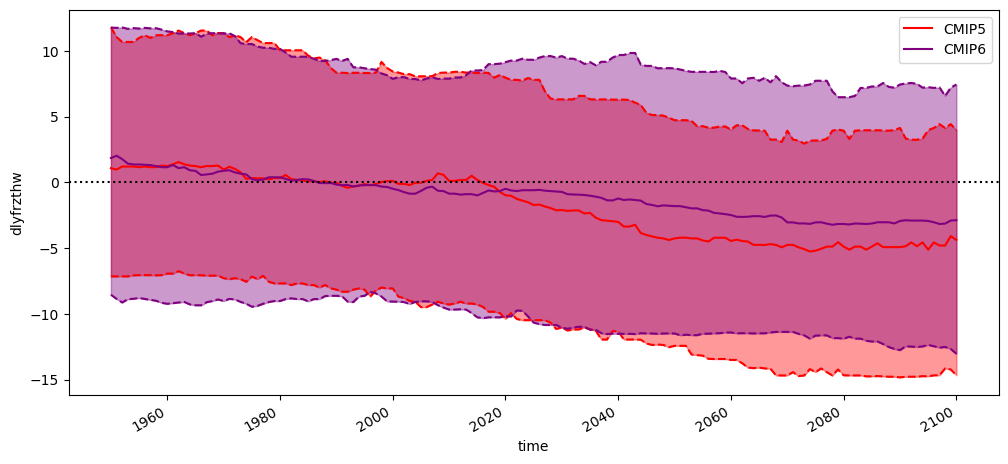

In [26]:
fig, ax = plt.subplots(figsize=(12, 5))

for da, col in zip([tdCMIP5, tdCMIP6], ['red', 'purple']):
    ax.fill_between(
        da.convert_calendar('standard').time,
        da.sel(quantile=0.1),
        da.sel(quantile=0.9),
        color=col,
        alpha=0.4,
    )
    da.convert_calendar('standard').sel(quantile=0.1).plot(ax=ax, color=col, linestyle='--')
    da.convert_calendar('standard').sel(quantile=0.9).plot(ax=ax, color=col, linestyle='--')
for da, col, lbl in zip([tdCMIP5, tdCMIP6], ['red', 'purple'], ['CMIP5', 'CMIP6']):
    da.convert_calendar('standard').sel(quantile=0.5).plot(ax=ax, label=lbl, color=col)
ax.legend()
ax.set_title('')
ax.axhline(0, color='k', linestyle=':')
fig.savefig('Deltaseries_raw_prob-reg.png', bbox_inches='tight')

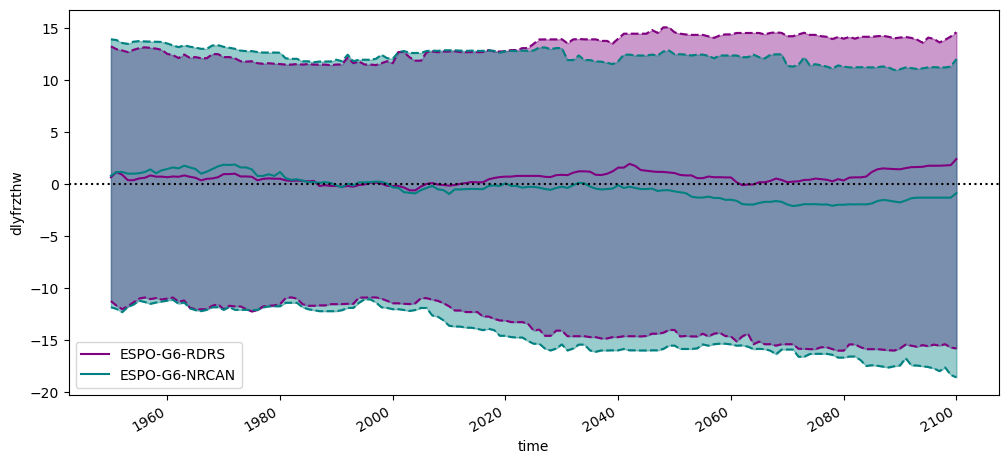

In [27]:
fig, ax = plt.subplots(figsize=(12, 5))

for da, col in zip([tdEG6R2, tdEG6N1], ['purple', 'teal']):
    ax.fill_between(
        da.convert_calendar('standard').time,
        da.sel(quantile=0.1),
        da.sel(quantile=0.9),
        color=col,
        alpha=0.4,
    )
    da.convert_calendar('standard').sel(quantile=0.1).plot(ax=ax, color=col, linestyle='--')
    da.convert_calendar('standard').sel(quantile=0.9).plot(ax=ax, color=col, linestyle='--')
for da, col, lbl in zip([tdEG6R2, tdEG6N1], ['purple', 'teal'],['ESPO-G6-RDRS', 'ESPO-G6-NRCAN']):
    da.convert_calendar('standard').sel(quantile=0.5).plot(ax=ax, label=lbl, color=col)
ax.legend()
ax.set_title('')
ax.axhline(0, color='k', linestyle=':')
fig.savefig('Deltaseries_ESPO_prob-reg.png', bbox_inches='tight')

# Carte référence

In [186]:
rdrs = (
    xr.open_zarr(
        '/exec/pbourg/ESPO-G/indicators/raw/RDRS/GouvCan_RDRS_NAM_AS-JAN.zarr/',
        decode_timedelta=False
    )
    .set_coords(['lon_bounds', 'lat_bounds'])
    .dlyfrzthw
    .pipe(lambda ds: xs.extract.clisops_subset(
        ds,
        region={'name': 'QC', 'method': 'shape', 'shape': {'shape': '/exec/pbourg/PC/20230406/regions_simplified_qc.geojson'}}
    ))
    .sel(time=slice('1981', '2010')).mean('time')
)

/home/pbourg/Projets/xscen/xscen/extract.py:76: UserWarning: Loading longitude and latitude for more efficient subsetting.


In [187]:
nrcan = (
    xr.open_zarr(
        '/scen3/scenario/netcdf/ouranos/portraits-clim-1.1/zarr/NRCAN_NRCAN_obs_CAN_AS-JAN_1950-2013.zarr/',
        decode_timedelta=False
    )
    .dlyfrzthw
    .pipe(lambda ds: xs.extract.clisops_subset(
        ds,
        region={'name': 'QC', 'method': 'shape', 'shape': {'shape': '/exec/pbourg/PC/20230406/regions_simplified_qc.geojson'}}
    ))
    .sel(time=slice('1981', '2010')).mean('time')
)

In [188]:
rdrs, nrcan = dask.compute(rdrs, nrcan)

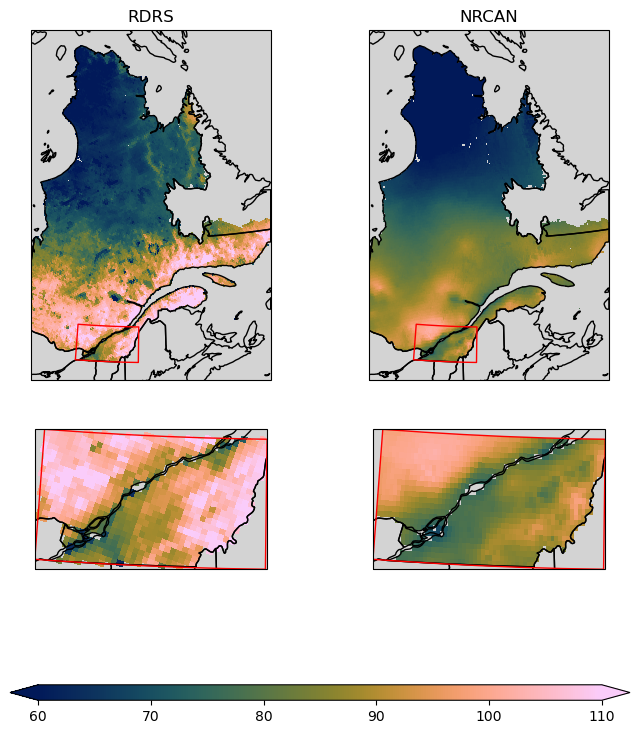

In [189]:
fig, axs = plt.subplots(
    2, 2,
    figsize=(8, 10),
    subplot_kw={'projection': crs.UTM(19)},
    gridspec_kw={'height_ratios': [2.5, 1]}
)

vmax = 110
vmin = 60

for ds, p, lbl, ax in zip([rdrs, nrcan], [pRD, pPC], ['RDRS', 'NRCAN'], axs[0]):
    m = ds.plot(
        ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False,
        transform=p,
    )
    ax.set_extent((-83, -55, 44, 63), crs=pPC)
    ax.set_title(lbl)
    ax.add_feature(cfeat.STATES)
    ax.add_geometries([pgp], crs=pPC, facecolor='none', edgecolor='r')
    ax.set_facecolor('lightgrey')
for ds, p, lbl, ax in zip([rdrs, nrcan], [pRD, pPC], ['RDRS', 'NRCAN'], axs[1]):
    m = xs.extract.clisops_subset(ds, region=probreg).plot(
        ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False,
        transform=p,
    )
    ax.set_extent((-75, -70, 45, 47), crs=pPC)
    ax.add_feature(cfeat.STATES)
    ax.add_geometries([pgp], crs=pPC, facecolor='none', edgecolor='r')
    ax.set_facecolor('lightgrey')
    ax.set_title('')
fig.colorbar(m, ax=axs, extend='both', orientation='horizontal', aspect=40)
fig.savefig('Ref_maps.png', bbox_inches='tight')

In [190]:
for kk, dd in cat.search(xrfreq='D', domain='prob-reg', experiment=['rcp45', 'ssp245'], variable=['tasmin', 'tasmax'], bias_adjust_project=['ESPO-TN', 'pcic', 'raw']).items():
    if len(dd.df.path) > 1:
        print(dd.df['path'].values)

['/exec/pbourg/ESPO-G/indsanal/day_CanDCS-U6_CMIP6_ScenarioMIP_CNRM-ESM2-1_CNRM-ESM2-1_ssp245_r1i1p1f2_CAN_prob-reg.zarr'
 '/exec/pbourg/ESPO-G/indsanal/day_CanDCS-U6_CMIP6_ScenarioMIP_CNRM-ESM2-1_CNRM-ESM2-1_ssp245_r1i1p1f1_CAN_prob-reg.zarr']


esm_datasource:
  args:
    aggregations:
    - !!python/object:intake_esm.cat.Aggregation
      __dict__:
        attribute_name: date_start
        options:
          dim: time
        type: !!python/object/apply:intake_esm.cat.AggregationType
        - join_existing
      __fields_set__: !!set
        attribute_name: null
        options: null
        type: null
      __private_attribute_values__: {}
    - !!python/object:intake_esm.cat.Aggregation
      __dict__:
        attribute_name: variable
        options: {}
        type: !!python/object/apply:intake_esm.cat.AggregationType
        - union
      __fields_set__: !!set
        attribute_name: null
        options: null
        type: null
      __private_attribute_values__: {}
    data_format: null
    format_column_name: format
    intake_kwargs:
      metadata: {}
    key: pcic_CMIP6_CNRM-ESM2-1_ssp245_prob-reg.prob-reg.biasajusted.D
    path_column_name: path
    records:
    - activity: .nan
      bias_adjust_institution: .